# GSEA with gseapy

In [1]:
#Boilerplate Import 
import sys
sys.path.append('..')
import os
from itertools import chain
from collections import defaultdict
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from scripts import utils
from scripts.analysis import build_loci

In [2]:
BASE = '../data'

unenr_grouped_loci = utils.load(os.path.join(BASE,"unenriched_grouped_loci_adj.pkl.gz"))
enr_grouped_loci = utils.load(os.path.join(BASE,"enriched_grouped_loci_filt1_adj.pkl.gz"))
grouped_loci = utils.load(os.path.join(BASE,"grouped_loci_filt1.pkl.gz"))

In [3]:
import gseapy as gp
import goatools

obodag = goatools.obo_parser.GODag('go-basic.obo')

load obo file go-basic.obo
go-basic.obo: fmt(1.2) rel(2016-07-16) 46,953 GO Terms


In [4]:
def make_ranked_df(grouped_loci):
    df = build_loci.get_sig_df(grouped_loci)
    
    # set differentially expressed, but insignificant loci to the center rank of the gene list
    df['logfc'] = df.where((abs(df['logfc']) <= 2) | (df['p_value'] <= 0.05))['logfc'].replace(np.nan, 0)
    
    # Right now FC ratios are light/heavy
    # light == Tcell and heavy == RAG
    # GSEA goes from low to High, so negative logFC values will come first
    # This will give genes high in RAG highest priority
    # Switching the sign with put the genes highest in Tcell mice up first
    df['logfc'] = -1 * df['logfc']
    
    # filter out the mouse and human genes
    mh_loci = build_loci.get_annotation_df(grouped_loci).query('mouse_human').index.tolist()
    df = df.query('~(id in {})'.format(mh_loci))

    
    # prep the ranking dataframe to gesapy specs.
    rank_df = df[['id', 'logfc']].rename(columns={'id': 'gene_name', 'logfc': 'rank'})
    
    return rank_df.sort_values('rank').reset_index(drop=True)


In [5]:
def make_go2Gene_map(grouped_loci, ontology='MF'):
    ontology_map = {'MF': 'molecular_function', 'BP': 'biological_process', 'CC': 'cellular_component'}
    
    out = defaultdict(set)    
    for l in grouped_loci:
        if 'go' in l.annotations and l.avg_ratio != 0:
            for go in l.annotations['go']:
                if obodag[go].namespace == ontology_map[ontology]:
                    out[go].add(l.cluster_id)
                    for parent in obodag[go].get_all_parents():
                        if obodag[parent].namespace == ontology_map[ontology]:
                            out[parent].add(l.cluster_id)
                
    return out

In [6]:
def filter_go2gene_map(go_locus):
    
    # Remove "very broad" gene sets. Arbitrary definition: gene sets that emcompass >50% of all IDs
    all_ids = set(chain(*go_locus.values()))
    go_locus = {key: value for (key, value) in go_locus.items() if len(value) / len(all_ids) <= 0.5}

    # Remove terms with less than 5 members: changed from 10 to 5 becasue small #s of proteins compared
    # to what you would find wiht genes
    go_locus = {key: value for (key, value) in go_locus.items() if len(value) >= 5}

    # Remove child terms with identical gene sets as their parents
    to_remove = set()
    for parent in go_locus.keys():
        # If child term has exact same members as parent, remove
        child_ids = [x.id for x in obodag[parent].children if x.id in go_locus.keys()]
        for child in child_ids:
            if go_locus[child] == go_locus[parent]:
                to_remove.add(child)
    go_locus = {key: value for (key, value) in go_locus.items() if key not in to_remove}

    # Remove sibling terms with identical gene sets
    to_remove = set()
    to_keep = set()
    for brother in go_locus.keys():
        to_keep.add(brother) # make sure filtered out siblings don't filter out ones we want to keep
        for parent in obodag[brother].parents:
            siblings = set([y.id for y in parent.children])
            siblings.remove(brother)
            for sibling in siblings:
                if sibling in go_locus.keys() and go_locus[brother] == go_locus[sibling] and not sibling in to_keep:
                    to_remove.add(sibling)
    go_locus = {key: value for (key, value) in go_locus.items() if key not in to_remove}

    return go_locus

In [7]:
def gomap_to_csv(go2gene, out_file = 'test.tsv'):

    out = ""
    for term, loci in go2gene.items():
        out += "{}\t".format(term)
        out += "{}\t".format(obodag[term].name)
        out += '\t'.join(list(map(str,loci)))
        out += '\n'
        
    with open(out_file, 'w') as fout:
        fout.write(out)

In [8]:
def run_go_gsea(rank_df, g2g_map, seed):
    """
    A ranked df and go2gene mapping returns the result dataframe for GSEA against all go-Terms
    
    loci must be grouped such that avg_ratio and p-values are correct for 1 phenotype
    see rt_unenr_grouped_loci above for example
    """
    import gseapy as gp
        
    # save the go 2 gene map, since gseapy doesn't seem to be able to use one already in memory
    gomap_to_csv(g2g_map, 'temp.gmt')
    
    res = gp.prerank(rnk=rank_df, gene_sets='temp.gmt', outdir='tmp', min_size = 5, max_size=500, 
                     graph_num = len(g2g_map), savefigs=False, seed=seed)
      
    def get_go_name(term):
        return obodag[term].name
    
    res['name'] = res.index.map(get_go_name)
    
    return res.sort_values('nes', ascending=False)

In [9]:
def plot_gsea_result(row, rank):
    return gp.gsea_plot.gsea_plot(rank, row['name'], row.hit_index, row.nes, row.pval, row.fdr, row.rank_ES, phenoPos='Tcell', phenoNeg='RAG')

In [10]:
mf_map = make_go2Gene_map(unenr_grouped_loci)
mf_map_f = filter_go2gene_map(mf_map)

print('Unfiltered: {}\tFiltered: {}'.format(len(mf_map), len(mf_map_f)))

Unfiltered: 516	Filtered: 198


In [11]:
bp_map = make_go2Gene_map(unenr_grouped_loci, 'BP')
bp_map_f = filter_go2gene_map(bp_map)

print('Unfiltered: {}\tFiltered: {}'.format(len(bp_map), len(bp_map_f)))

Unfiltered: 612	Filtered: 208


In [12]:
cc_map = make_go2Gene_map(unenr_grouped_loci, 'CC')
cc_map_f = filter_go2gene_map(cc_map)

print('Unfiltered: {}\tFiltered: {}'.format(len(cc_map), len(cc_map_f)))

Unfiltered: 102	Filtered: 48


In [13]:
unen_rank =  make_ranked_df(unenr_grouped_loci)

In [14]:
import warnings
warnings.filterwarnings('ignore')

mf_un_res = run_go_gsea(unen_rank, mf_map_f, seed=1111)
bp_un_res = run_go_gsea(unen_rank, bp_map_f, seed=2222)
cc_un_res = run_go_gsea(unen_rank, cc_map_f, seed=3333)

119 gene_sets have been filtered out when max_size=500 and min_size=5
79 gene_sets used for further calculating
Start to compute enrichment socres...................... Wed Oct 12 12:39:00 2016
Start to compute esnulls................................ Wed Oct 12 12:39:00 2016
......This step might take a while to run. Be patient...
Start to compute pvals.................................. Wed Oct 12 12:39:12 2016
start to compute fdrs................................... Wed Oct 12 12:39:12 2016
Statistial testing finished............................. Wed Oct 12 12:39:12 2016
Start to generate gseapy reports, and produce figures... Wed Oct 12 12:39:12 2016
Congratulations. GSEAPY run successfully................
The Job is done.................................Goodbye! Wed Oct 12 12:39:12 2016
103 gene_sets have been filtered out when max_size=500 and min_size=5
105 gene_sets used for further calculating
Start to compute enrichment socres...................... Wed Oct 12 12:39:14 2016
Start

In [15]:
mf_un_TC = mf_un_res.query('nes > 0 and pval < 0.05').sort_values('nes', ascending=False)
mf_un_RAG = mf_un_res.query('nes < 0 and pval < 0.05').sort_values('nes', ascending=True)

bp_un_TC = bp_un_res.query('nes > 0 and pval < 0.05').sort_values('nes', ascending=False)
bp_un_RAG = bp_un_res.query('nes < 0 and pval < 0.05').sort_values('nes', ascending=True)

cc_un_TC = cc_un_res.query('nes > 0 and pval < 0.05').sort_values('nes', ascending=False)
cc_un_RAG = cc_un_res.query('nes < 0 and pval < 0.05').sort_values('nes', ascending=True)

### Molecular Function - Up in Tcell

In [16]:
res_cols = ['name', 'es', 'nes', 'pval', 'fdr', 'gene_set_size', 'matched_size']

In [17]:
mf_un_TC[res_cols]

,name,es,nes,pval,fdr,gene_set_size,matched_size
Enrich_terms,,,,,,,
GO:0016860,intramolecular oxidoreductase activity,0.777333,2.103496,0.000000,0.093390,53,16
GO:0051287,NAD binding,0.674523,1.993045,0.000000,0.077047,39,24
GO:0016614,"oxidoreductase activity, acting on CH-OH group...",0.571832,1.895266,0.000000,0.089888,58,32
GO:0016620,"oxidoreductase activity, acting on the aldehyd...",0.544212,1.789906,0.004975,0.116445,66,36
GO:0016853,isomerase activity,0.722284,1.779670,0.005056,0.098526,141,89
GO:0016868,"intramolecular transferase activity, phosphotr...",0.849425,1.671280,0.018519,0.145921,53,52
GO:0000287,magnesium ion binding,0.461014,1.641705,0.008357,0.147256,72,51
GO:0016616,"oxidoreductase activity, acting on the CH-OH g...",0.526375,1.626237,0.017241,0.137604,54,30
GO:0004619,phosphoglycerate mutase activity,0.885886,1.608585,0.036999,0.134637,41,41


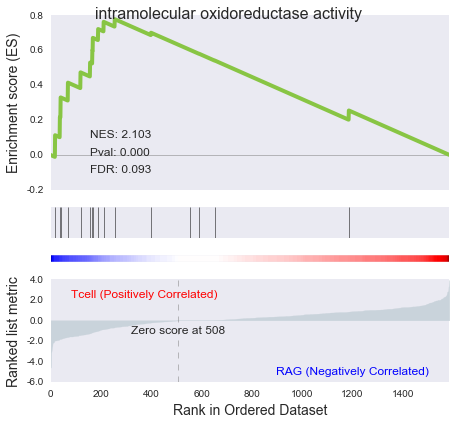

In [18]:
sns.set_style('dark')
plot_gsea_result(mf_un_res.iloc[0], unen_rank)

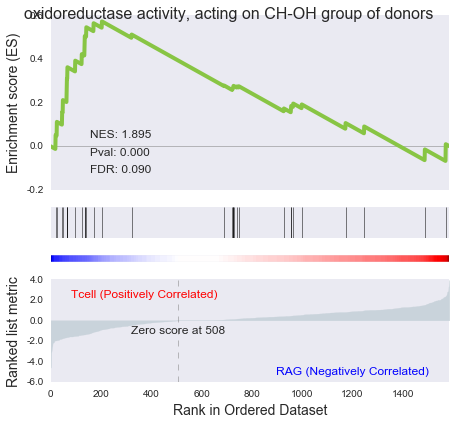

In [19]:
sns.set_style('dark')
plot_gsea_result(mf_un_res.iloc[2], unen_rank)

### Biological Process - Up in Tcell

In [20]:
bp_un_TC[res_cols]

,name,es,nes,pval,fdr,gene_set_size,matched_size
Enrich_terms,,,,,,,
GO:0044712,single-organism catabolic process,0.482484,2.100933,0.000000,0.148252,227,145
GO:0016052,carbohydrate catabolic process,0.485297,2.075497,0.000000,0.081393,211,138
GO:0046939,nucleotide phosphorylation,0.479383,2.063363,0.000000,0.056685,202,132
GO:0072524,pyridine-containing compound metabolic process,0.479383,2.048848,0.000000,0.045784,204,132
GO:0009132,nucleoside diphosphate metabolic process,0.479383,2.031847,0.000000,0.037790,202,132
GO:0009185,ribonucleoside diphosphate metabolic process,0.479383,2.026852,0.000000,0.032460,201,132
GO:0006733,oxidoreduction coenzyme metabolic process,0.479383,2.021672,0.000000,0.028654,204,132
GO:0005975,carbohydrate metabolic process,0.429715,1.999821,0.000000,0.028342,499,312
GO:0009056,catabolic process,0.443557,1.945204,0.000000,0.033268,255,161


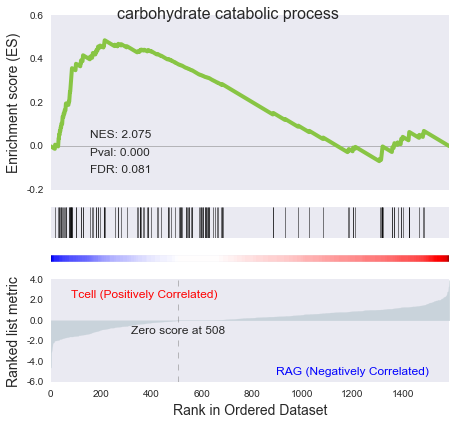

In [21]:
p = plot_gsea_result(bp_un_res.loc['GO:0016052'], unen_rank)
p.savefig(os.path.join(BASE, 'GSEA-carb-cat-proc.svg'))
p

### Cellular Component - Up in Tcell

In [22]:
cc_un_TC[res_cols]

,name,es,nes,pval,fdr,gene_set_size,matched_size
Enrich_terms,,,,,,,
GO:0005737,cytoplasm,0.418887,1.456956,0.04023,0.400523,124,44


### Molecular Function - Up in RAG

In [23]:
mf_un_RAG[res_cols]

,name,es,nes,pval,fdr,gene_set_size,matched_size
Enrich_terms,,,,,,,
GO:0034062,RNA polymerase activity,-0.572761,-2.212322,0.000000,0.000000,131,83
GO:0016779,nucleotidyltransferase activity,-0.513106,-1.978109,0.000000,0.000000,182,118
GO:0016781,"phosphotransferase activity, paired acceptors",-0.477405,-1.939715,0.000000,0.000000,101,73
GO:0022804,active transmembrane transporter activity,-0.657739,-1.927619,0.000000,0.000000,95,34
GO:0022857,transmembrane transporter activity,-0.657739,-1.896725,0.000000,0.000000,99,34
GO:0032559,adenyl ribonucleotide binding,-0.502140,-1.894638,0.000000,0.000000,412,200
GO:0030554,adenyl nucleotide binding,-0.491581,-1.858875,0.000000,0.000125,417,202
GO:0003677,DNA binding,-0.488277,-1.808561,0.000000,0.000327,134,86
GO:0016772,"transferase activity, transferring phosphorus-...",-0.394758,-1.739857,0.000000,0.001840,422,258


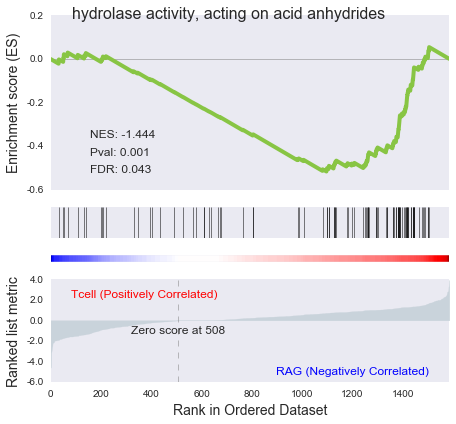

In [24]:
plot_gsea_result(mf_un_res.loc['GO:0016817'], unen_rank)

### Biological Process - Up in RAG

In [25]:
bp_un_RAG[res_cols]

,name,es,nes,pval,fdr,gene_set_size,matched_size
Enrich_terms,,,,,,,
GO:0097659,nucleic acid-templated transcription,-0.572761,-2.229154,0.000000,0.000000,131,83
GO:0016070,RNA metabolic process,-0.521299,-2.208360,0.000000,0.000000,175,100
GO:0032774,RNA biosynthetic process,-0.572761,-2.205054,0.000000,0.000000,133,83
GO:0090304,nucleic acid metabolic process,-0.522479,-2.189166,0.000000,0.000000,177,101
GO:0008643,carbohydrate transport,-0.800661,-1.955120,0.000000,0.000150,30,12
GO:0034654,nucleobase-containing compound biosynthetic pr...,-0.498514,-1.890996,0.000000,0.000251,198,97
GO:0019438,aromatic compound biosynthetic process,-0.496872,-1.880078,0.000000,0.000322,215,104
GO:1901362,organic cyclic compound biosynthetic process,-0.490641,-1.841421,0.000000,0.000282,218,106
GO:0018130,heterocycle biosynthetic process,-0.490641,-1.824655,0.000000,0.000334,218,106


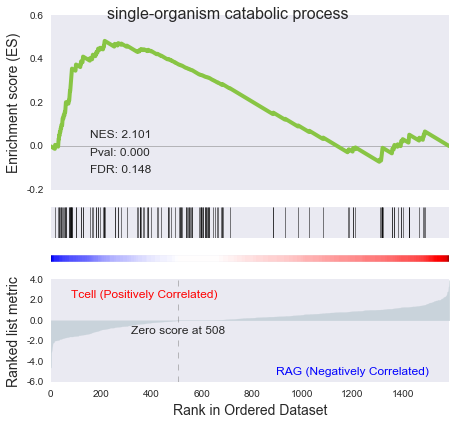

In [26]:
plot_gsea_result(bp_un_res.iloc[0], unen_rank)

### Cellular Component - Up in RAG

In [27]:
cc_un_RAG[res_cols]

,name,es,nes,pval,fdr,gene_set_size,matched_size
Enrich_terms,,,,,,,
GO:0031224,intrinsic component of membrane,-0.795462,-1.410756,0.000000,0.227188,46,19
GO:0033178,"proton-transporting two-sector ATPase complex,...",-0.665441,-1.372360,0.033333,0.184293,41,13
GO:0044425,membrane part,-0.630280,-1.322298,0.004000,0.216332,122,50
GO:0098796,membrane protein complex,-0.629332,-1.245670,0.025100,0.189740,79,35


## GSEA on BioGlyCMK Enriched Samples

In [28]:
enr_rank =  make_ranked_df(enr_grouped_loci)

In [29]:
enr_mf_map = make_go2Gene_map(enr_grouped_loci)
enr_mf_map_f = filter_go2gene_map(enr_mf_map)
print('MF Unfiltered: {}\tFiltered: {}'.format(len(enr_mf_map), len(enr_mf_map_f)))

enr_bp_map = make_go2Gene_map(enr_grouped_loci, 'BP')
enr_bp_map_f = filter_go2gene_map(enr_bp_map)
print('BP Unfiltered: {}\tFiltered: {}'.format(len(enr_bp_map), len(enr_bp_map_f)))

enr_cc_map = make_go2Gene_map(enr_grouped_loci, 'CC')
enr_cc_map_f = filter_go2gene_map(enr_cc_map)
print('CC Unfiltered: {}\tFiltered: {}'.format(len(enr_cc_map), len(enr_cc_map_f)))

MF Unfiltered: 481	Filtered: 182
BP Unfiltered: 560	Filtered: 186
CC Unfiltered: 99	Filtered: 28


In [30]:
mf_enr_res = run_go_gsea(enr_rank, enr_mf_map_f, seed=1234)
bp_enr_res = run_go_gsea(enr_rank, enr_bp_map_f, seed=4321)
cc_enr_res = run_go_gsea(enr_rank, enr_cc_map_f, seed=2143)

112 gene_sets have been filtered out when max_size=500 and min_size=5
70 gene_sets used for further calculating
Start to compute enrichment socres...................... Wed Oct 12 12:39:39 2016
Start to compute esnulls................................ Wed Oct 12 12:39:39 2016
......This step might take a while to run. Be patient...
Start to compute pvals.................................. Wed Oct 12 12:39:45 2016
start to compute fdrs................................... Wed Oct 12 12:39:45 2016
Statistial testing finished............................. Wed Oct 12 12:39:45 2016
Start to generate gseapy reports, and produce figures... Wed Oct 12 12:39:45 2016
Congratulations. GSEAPY run successfully................
The Job is done.................................Goodbye! Wed Oct 12 12:39:45 2016
107 gene_sets have been filtered out when max_size=500 and min_size=5
79 gene_sets used for further calculating
Start to compute enrichment socres...................... Wed Oct 12 12:39:46 2016
Start 

In [31]:
mf_enr_TC = mf_enr_res.query('nes > 0 and pval < 0.05').sort_values('nes', ascending=False)
mf_enr_RAG = mf_enr_res.query('nes < 0 and pval < 0.05').sort_values('nes', ascending=True)

bp_enr_TC = bp_enr_res.query('nes > 0 and pval < 0.05').sort_values('nes', ascending=False)
bp_enr_RAG = bp_enr_res.query('nes < 0 and pval < 0.05').sort_values('nes', ascending=True)

cc_enr_TC = cc_enr_res.query('nes > 0 and pval < 0.05').sort_values('nes', ascending=False)
cc_enr_RAG = cc_enr_res.query('nes < 0 and pval < 0.05').sort_values('nes', ascending=True)

### Up in T-Cell: Molecular Function

In [32]:
mf_enr_TC[res_cols]

,name,es,nes,pval,fdr,gene_set_size,matched_size
Enrich_terms,,,,,,,
GO:0008233,peptidase activity,0.690534,1.979171,0.000000,0.124186,69,20
GO:0005515,protein binding,0.659422,1.811603,0.000000,0.135225,70,19
GO:0004175,endopeptidase activity,0.848543,1.804052,0.000000,0.093370,28,10
GO:0016810,"hydrolase activity, acting on carbon-nitrogen ...",0.590478,1.543655,0.031469,0.258722,34,16
GO:0004553,"hydrolase activity, hydrolyzing O-glycosyl com...",0.577203,1.505759,0.041667,0.245475,30,15
GO:0016798,"hydrolase activity, acting on glycosyl bonds",0.559066,1.480715,0.010417,0.228365,32,16
GO:0016787,hydrolase activity,0.333658,1.351906,0.033708,0.309603,266,112


In [33]:
obodag.query_term('GO:0016810')

GOTerm('GO:0016810'):
  depth:3
  level:3
  children: 20 items
  name:hydrolase activity, acting on carbon-nitrogen (but not peptide) bonds
  _parents: 1 items
    GO:0016787
  id:GO:0016810
  namespace:molecular_function
  is_obsolete:False
  parents: 1 items
    GO:0016787	level-02	depth-02	hydrolase activity [molecular_function] 
  alt_ids: 0 items

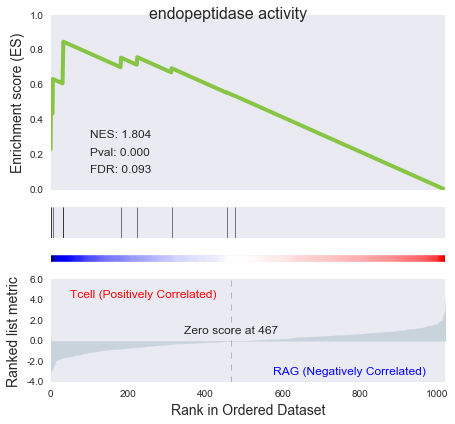

In [34]:
plot_gsea_result(mf_enr_res.loc['GO:0004175'], enr_rank)

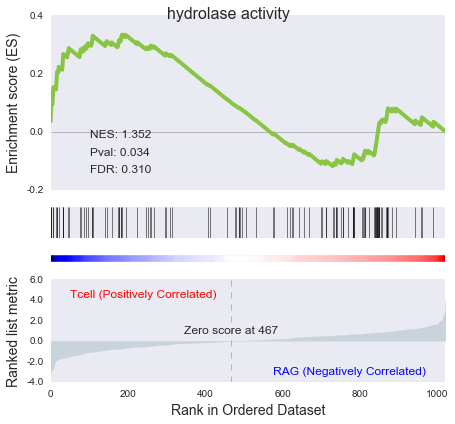

In [35]:
plot_gsea_result(mf_enr_res.loc['GO:0016787'], enr_rank)

### Up in T-Cell: Biological Process

In [36]:
bp_enr_TC[res_cols]

,name,es,nes,pval,fdr,gene_set_size,matched_size
Enrich_terms,,,,,,,
GO:0006508,proteolysis,0.666279,1.853513,0.000000,0.571539,66,21
GO:0034654,nucleobase-containing compound biosynthetic pr...,0.665961,1.731981,0.022388,0.476550,50,18
GO:0016070,RNA metabolic process,0.761404,1.712606,0.032086,0.348290,41,11
GO:0019538,protein metabolic process,0.540780,1.698587,0.000000,0.276512,130,37
GO:0043170,macromolecule metabolic process,0.456859,1.668666,0.000000,0.210906,218,69


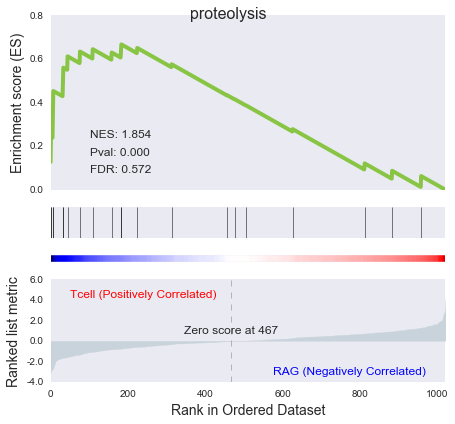

In [37]:
plot_gsea_result(bp_enr_res.loc['GO:0006508'], enr_rank)

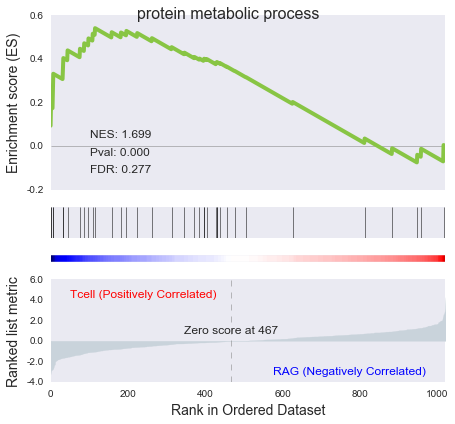

In [38]:
plot_gsea_result(bp_enr_res.loc['GO:0019538'], enr_rank)

### Up in T-Cell: Cellular Compnent

In [39]:
cc_enr_TC[res_cols]

,name,es,nes,pval,fdr,gene_set_size,matched_size
Enrich_terms,,,,,,,
GO:0016020,membrane,0.512463,1.187362,0.0,0.31921,46,12


### Up in RAG: Molecular Function

In [40]:
mf_enr_RAG[res_cols]

,name,es,nes,pval,fdr,gene_set_size,matched_size
Enrich_terms,,,,,,,
GO:0016781,"phosphotransferase activity, paired acceptors",-0.768675,-2.041416,0.000000,0.001282,124,38
GO:0001882,nucleoside binding,-0.432827,-2.034459,0.000000,0.000641,359,150
GO:0097367,carbohydrate derivative binding,-0.432827,-2.029062,0.000000,0.000427,362,150
GO:0035639,purine ribonucleoside triphosphate binding,-0.437262,-2.021658,0.000000,0.000320,352,146
GO:0032555,purine ribonucleotide binding,-0.437262,-1.995192,0.000000,0.000256,352,146
GO:0032553,ribonucleotide binding,-0.437262,-1.993665,0.000000,0.000214,353,146
GO:0001883,purine nucleoside binding,-0.437262,-1.993365,0.000000,0.000183,352,146
GO:0017076,purine nucleotide binding,-0.432791,-1.944868,0.000000,0.000481,364,150
GO:1901265,nucleoside phosphate binding,-0.386096,-1.921314,0.000000,0.000427,408,169


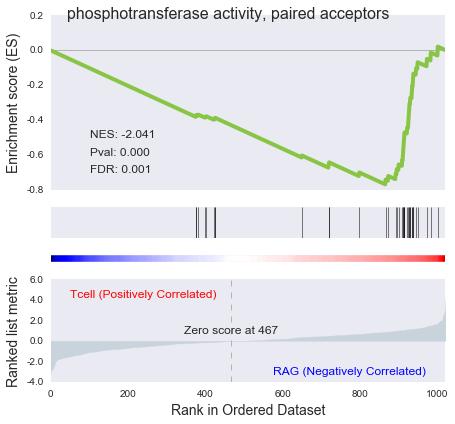

In [41]:
plot_gsea_result(mf_enr_res.loc['GO:0016781'], enr_rank)

### Up in RAG: Biological Process

In [42]:
bp_enr_RAG[res_cols]

,name,es,nes,pval,fdr,gene_set_size,matched_size
Enrich_terms,,,,,,,
GO:0006457,protein folding,-0.643530,-1.789091,0.016529,0.009816,35,12
GO:0016051,carbohydrate biosynthetic process,-0.509087,-1.572736,0.008143,0.072638,71,33
GO:0032787,monocarboxylic acid metabolic process,-0.434365,-1.548943,0.000000,0.067185,264,117
GO:0015672,monovalent inorganic cation transport,-0.618190,-1.496296,0.024113,0.093252,28,16
GO:0044283,small molecule biosynthetic process,-0.461843,-1.495053,0.017078,0.075125,93,36
GO:0006812,cation transport,-0.618190,-1.482765,0.021592,0.061513,32,16
GO:0006811,ion transport,-0.618190,-1.472528,0.030598,0.059141,34,16
GO:0016310,phosphorylation,-0.436276,-1.409350,0.010823,0.088802,243,105
GO:0006090,pyruvate metabolic process,-0.438201,-1.400599,0.005308,0.088344,235,104


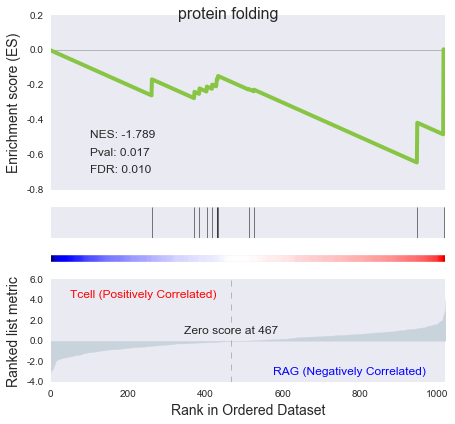

In [43]:
plot_gsea_result(bp_enr_res.loc['GO:0006457'], enr_rank)

### Up in RAG: Cellular Component

In [44]:
cc_enr_RAG[res_cols]

,name,es,nes,pval,fdr,gene_set_size,matched_size
Enrich_terms,,,,,,,
GO:0098796,membrane protein complex,-0.625146,-1.605151,0.010219,0.021926,28,18
GO:0043234,protein complex,-0.455758,-1.355616,0.031818,0.183508,94,60
GO:1902494,catalytic complex,-0.455299,-1.352485,0.033520,0.093422,77,56
